## Aims

* Illustrate which pixels have large RATE values
    - Additionally, we can try to
        * Show how this is a combination of the mean and variance of the effect size analogue posterior
        * Show how these pixels are different to those selected to the effect size analogue mean

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The code for has been hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Train network and compute RATE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import spearmanr, rankdata

In [5]:
# Load RATE / mean effect size analogue data
rate = np.load("rate_plot_arr.npy") # shape (n_classes, n_pixels) = (10, 324)
M_B = np.load("M_B_plot_arr.npy") # shape (n_classes, n_pixels) = (10, 324)
V_B = np.load("V_B_plot_arr.npy") # shape (n_classes, n_pixels, n_pixels) = (10, 324, 324)

C = rate.shape[0]
p = rate.shape[1]
image_size = int(p**0.5)

## Plots

### Plots leftover from earlier development

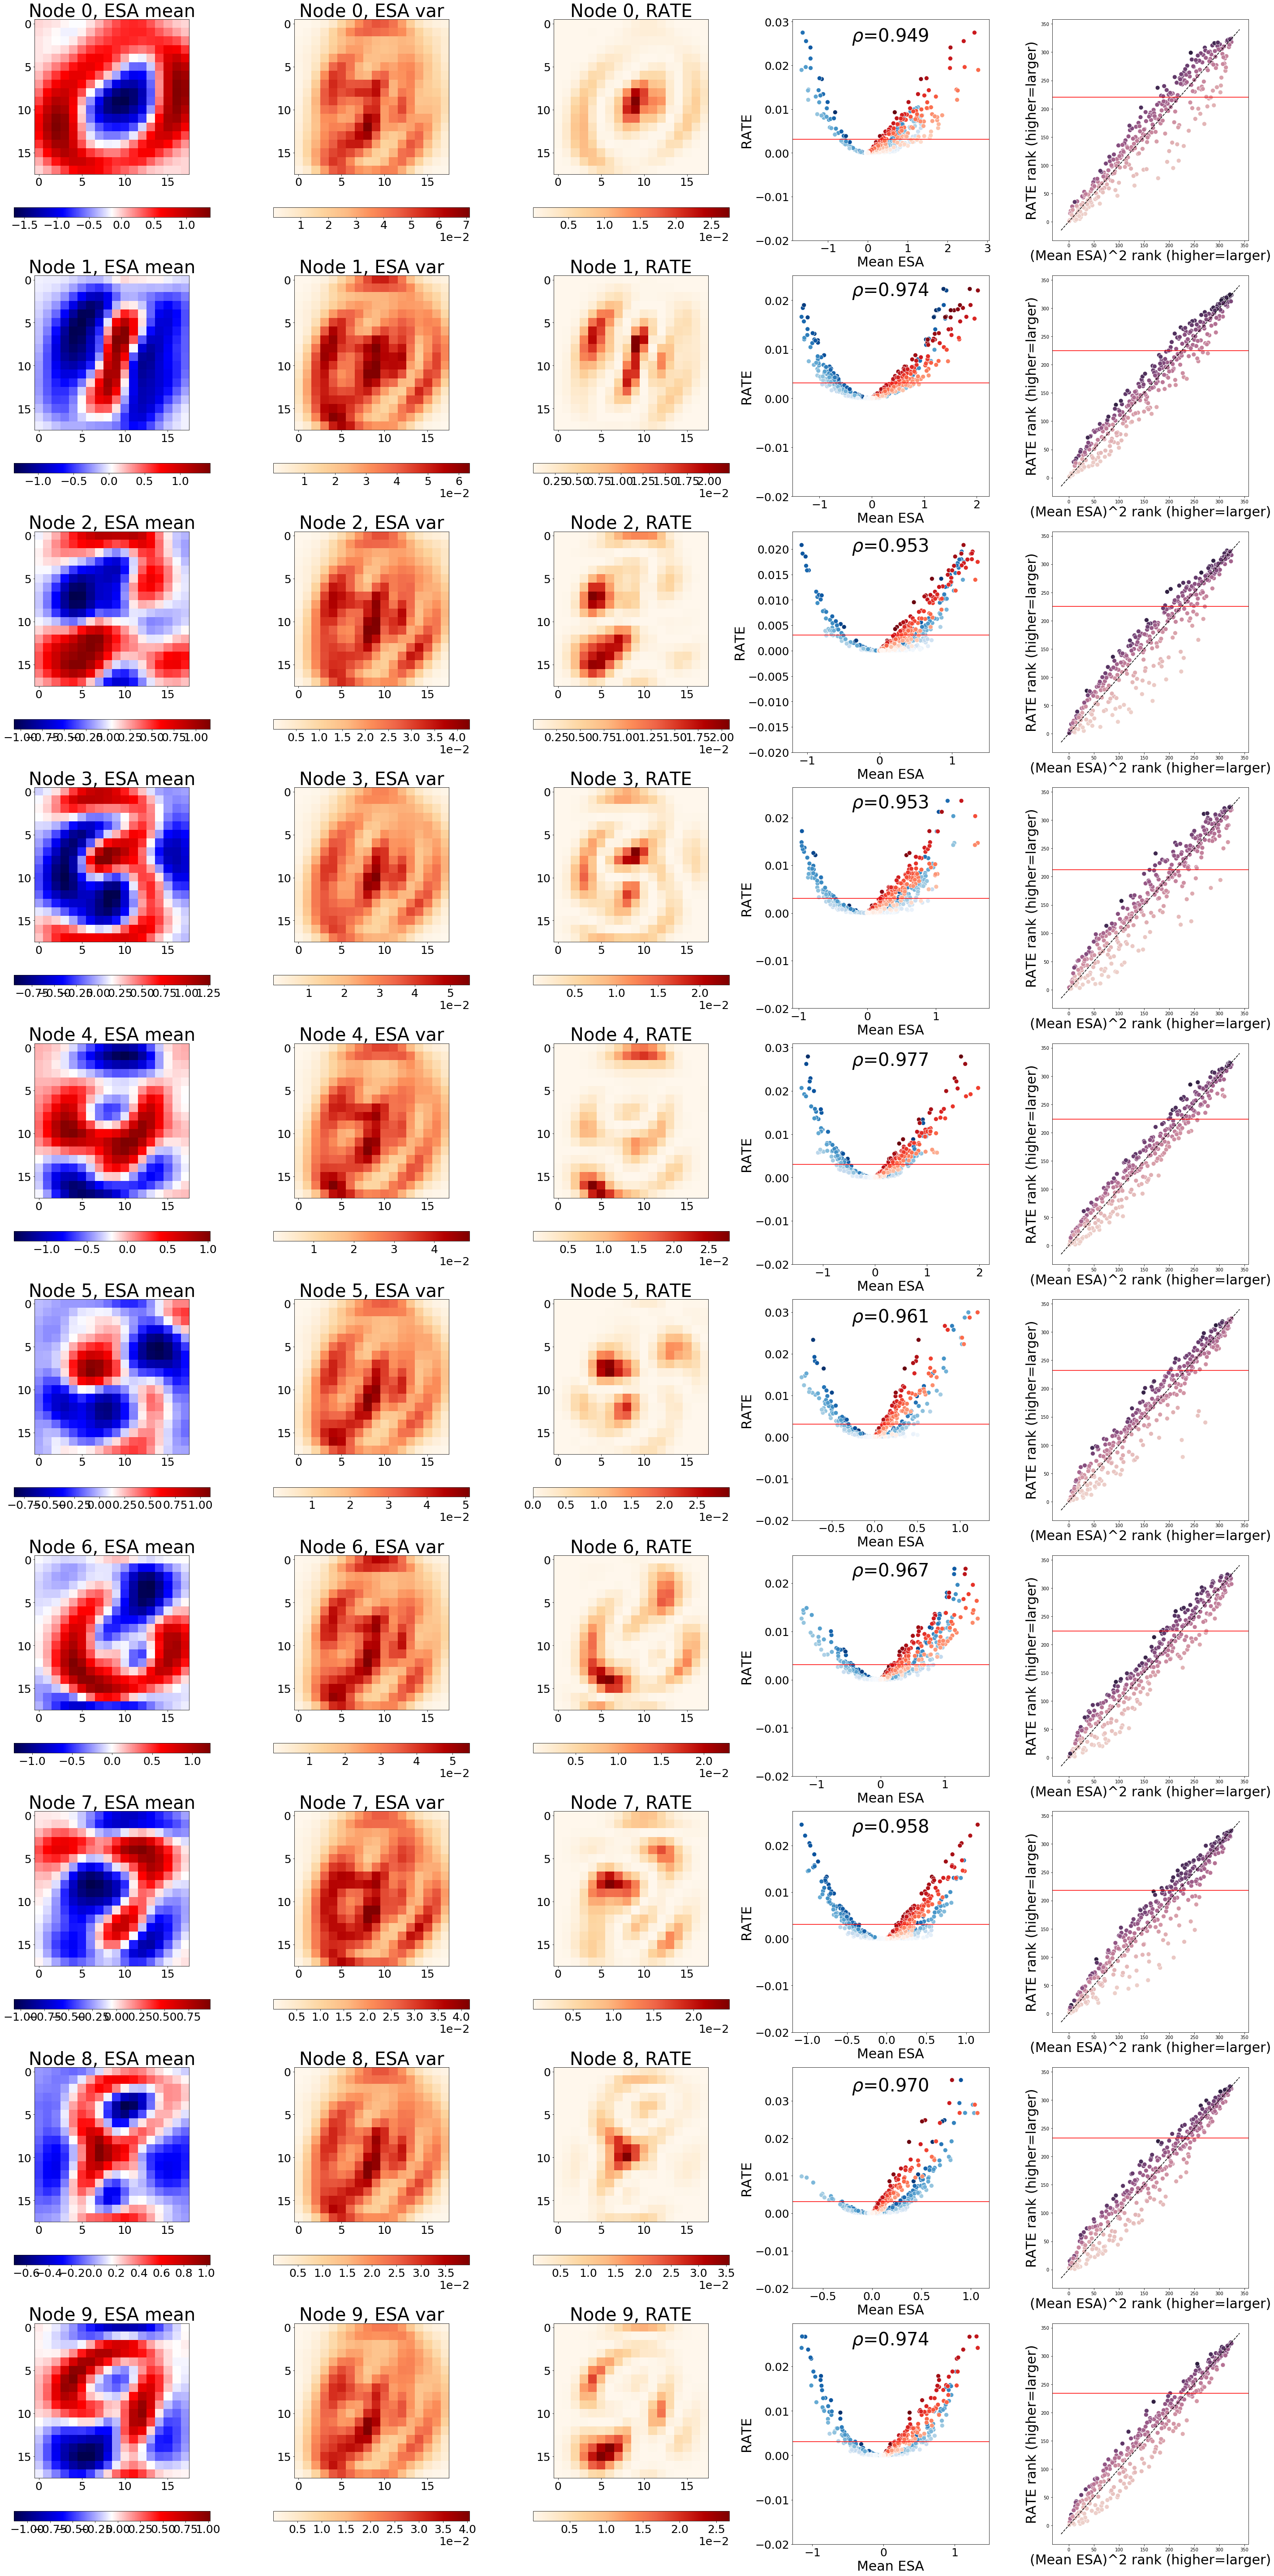

In [6]:
C_plot = 10 # Number of classes to plot

# Plot aesthetics
plotsize = 8
tickfontsize = 25
plottitlesize = 40
axislabelfontsize = 30
markersize = 100

# For standardising axis limits across rows
rate_max = np.amax(np.array(rate))
rate_min = np.amin(np.array(rate))
M_B_max = np.amax(M_B)
M_B_min = np.amin(M_B)

fig, axes = plt.subplots(C_plot, 5, figsize=(5*plotsize, C_plot*plotsize))

# Iterate over axes rows - one row per class (digit)
for idx, ax in enumerate(axes):
    ims = []
    
    # Plot titles for heatmaps
    ax[0].set_title("Node {}, ESA mean".format(idx), fontsize=plottitlesize)
    ax[1].set_title("Node {}, ESA var".format(idx), fontsize=plottitlesize)
    ax[2].set_title("Node {}, RATE".format(idx), fontsize=plottitlesize)

    # Heatmaps
    ims.append(ax[0].imshow(M_B[idx,:].reshape(image_size, image_size),
                                        interpolation="none",
                                        cmap="seismic"))
    ims.append(ax[1].imshow(np.diag(V_B[idx,:]).reshape(image_size, image_size),
                                        interpolation="none",
                                        cmap="OrRd"))
    ims.append(ax[2].imshow(rate[idx,:].reshape(image_size, image_size),
                                         interpolation="none",
                                         cmap="OrRd"))

    # Scatterplots
    hue = np.diag(V_B[idx,:])
    hue = hue/np.amax(hue)
    sns.scatterplot(M_B[idx,:], rate[idx,:],
                    palette="Blues", hue=hue, s=markersize,
                    label="Mean ESA vs RATE", ax=ax[3])
    sns.scatterplot(M_B[idx,:]**2.0, rate[idx,:],
                    palette="Reds", hue=hue, s=markersize,
                    label="(Mean ESA)^2 vs RATE", ax=ax[3])
    ax[3].set_xlabel("Mean ESA", fontsize=axislabelfontsize)
    ax[3].set_ylabel("RATE", fontsize=axislabelfontsize)
    ax[3].axhline(1.0/rate[idx,:].shape[0], color="red")
    ax[3].get_legend().remove()

    ylim = ax[3].get_ylim()
    xlim = ax[3].get_xlim()
    ax[3].text(0.3*(xlim[1]-xlim[0]) + xlim[0], 0.85*(ylim[1]-ylim[0]) + ylim[0], 
                   r'$\rho$={0:.3f}'.format(spearmanr(rate[idx,:],  M_B[idx,:]**2.0)[0]),
                  fontsize=axislabelfontsize+10)
    ax[3].set_ylim([-0.02, ylim[1]])
    
    # Rankings plot
    sns.scatterplot(rankdata(M_B[idx,:]**2.0), rankdata(rate[idx,:]), hue=hue, s=markersize, ax=ax[4])
    ax[4].set_xlabel("(Mean ESA)^2 rank (higher=larger)", fontsize=axislabelfontsize)
    ax[4].set_ylabel("RATE rank (higher=larger)", fontsize=axislabelfontsize)
    ax[4].get_legend().remove()
    ax[4].axhline(np.where(np.sort(rate[idx,:])<1.0/p)[0][-1], color="red")
    ax[4].plot(ax[4].get_xlim(), ax[4].get_ylim(), ls="--", color="black")
    
    # Tick font sizes on all plots
    for j in range(4):
        ax[j].tick_params("both", labelsize=tickfontsize)

    # Colourbars
    cbs = [fig.colorbar(ims[i], ax=ax[i], orientation="horizontal") for i in range(3)]
    for cb in cbs:
        cb.formatter.set_scientific(True)
        cb.formatter.set_powerlimits((0, 0))
        cb.update_ticks()
        cb.ax.xaxis.offsetText.set_fontsize(tickfontsize)
        cb.ax.tick_params("both", labelsize=tickfontsize)

plt.tight_layout()

### Description of plots

For the plots above:
* Each row of plots is for a single node of the final layer, which corresponds to a single class - this is why you can see the outline of each digit in the first three columns of plots. Each row contains plots showing (from left to right):

    1. the mean of the ESA (effect size analogue) posterior for that node (pixel-by-pixel)
    2. the variance of the ESA posterior for that node (pixel-by-pixel)
    3. the corresponding RATE values for that node (pixel-by-pixel)
    4. Scatter plots of the ESA and RATE values (blue) and the square of the ESA and RATE (orange). Also shown is the Spearman correlation (rho) between the square of the ESA and RATE (since ESA mean can be negative). The intensity of each point indicates the ESA posterior variance, with higher intensity indicating higher variance.
    5. The pixel rankings according to their RATE values vs the rankings according to the square of the ESA posterior mean. The color of the points indicates the variance of the ESA marginal posterior for each pixel, with a darker colour meaning a larger variance. It looks like the difference in ranking between RATE and mean ESA can be explained by the variance. The red line on this plot shows 1/p. The intensity of each point indicates the ESA posterior variance, with higher intensity indicating higher variance. If the rankings were identical all the points would lie on the diagonal, black line.
    
    
* RATE combines the information of the ESA posterior mean and covaraince when ranking the pixels. This can most clearly be seen from the final column of plots, as the difference in pixel ranking using RATE and (mean ESA)^2 can be explained by the ESA posterior variance of the pixel (larger variances lie in the upper-right part of the plot, which is where the RATE rank is higher than the mean ESA rank, and vice versa).

### Comments

The first row of plots are equivalent to those which appeared in the original NeurIPS paper (although those plots were for a deterministic network and these are the means of the effect size analogue posterior for a Bayesian network).

Of these plots, only the first three columns (and possibly the final column) are suitable to be included in the ICML paper. Ideally the information shown in these three plots can be combined into a single plot. This is shown in the final column of plots (RATE combines the information of the ESA posterior mean and covaraince when ranking the pixels) but without the spatial information of the pixels.

### Different colormaps for RATE plots

One option is to just include plots showing the RATE values for each node.

These tend to not show the digits as clearly as the effect size analogue posterior mean plots because most of the pixels have low RATE values. 

The right colourmap should show enough information, though (matplotlib colourmaps - https://matplotlib.org/examples/color/colormaps_reference.html).

A sequential colourmap is probably better because they do not show low values as white, although I don't think that they would print well in black and white.

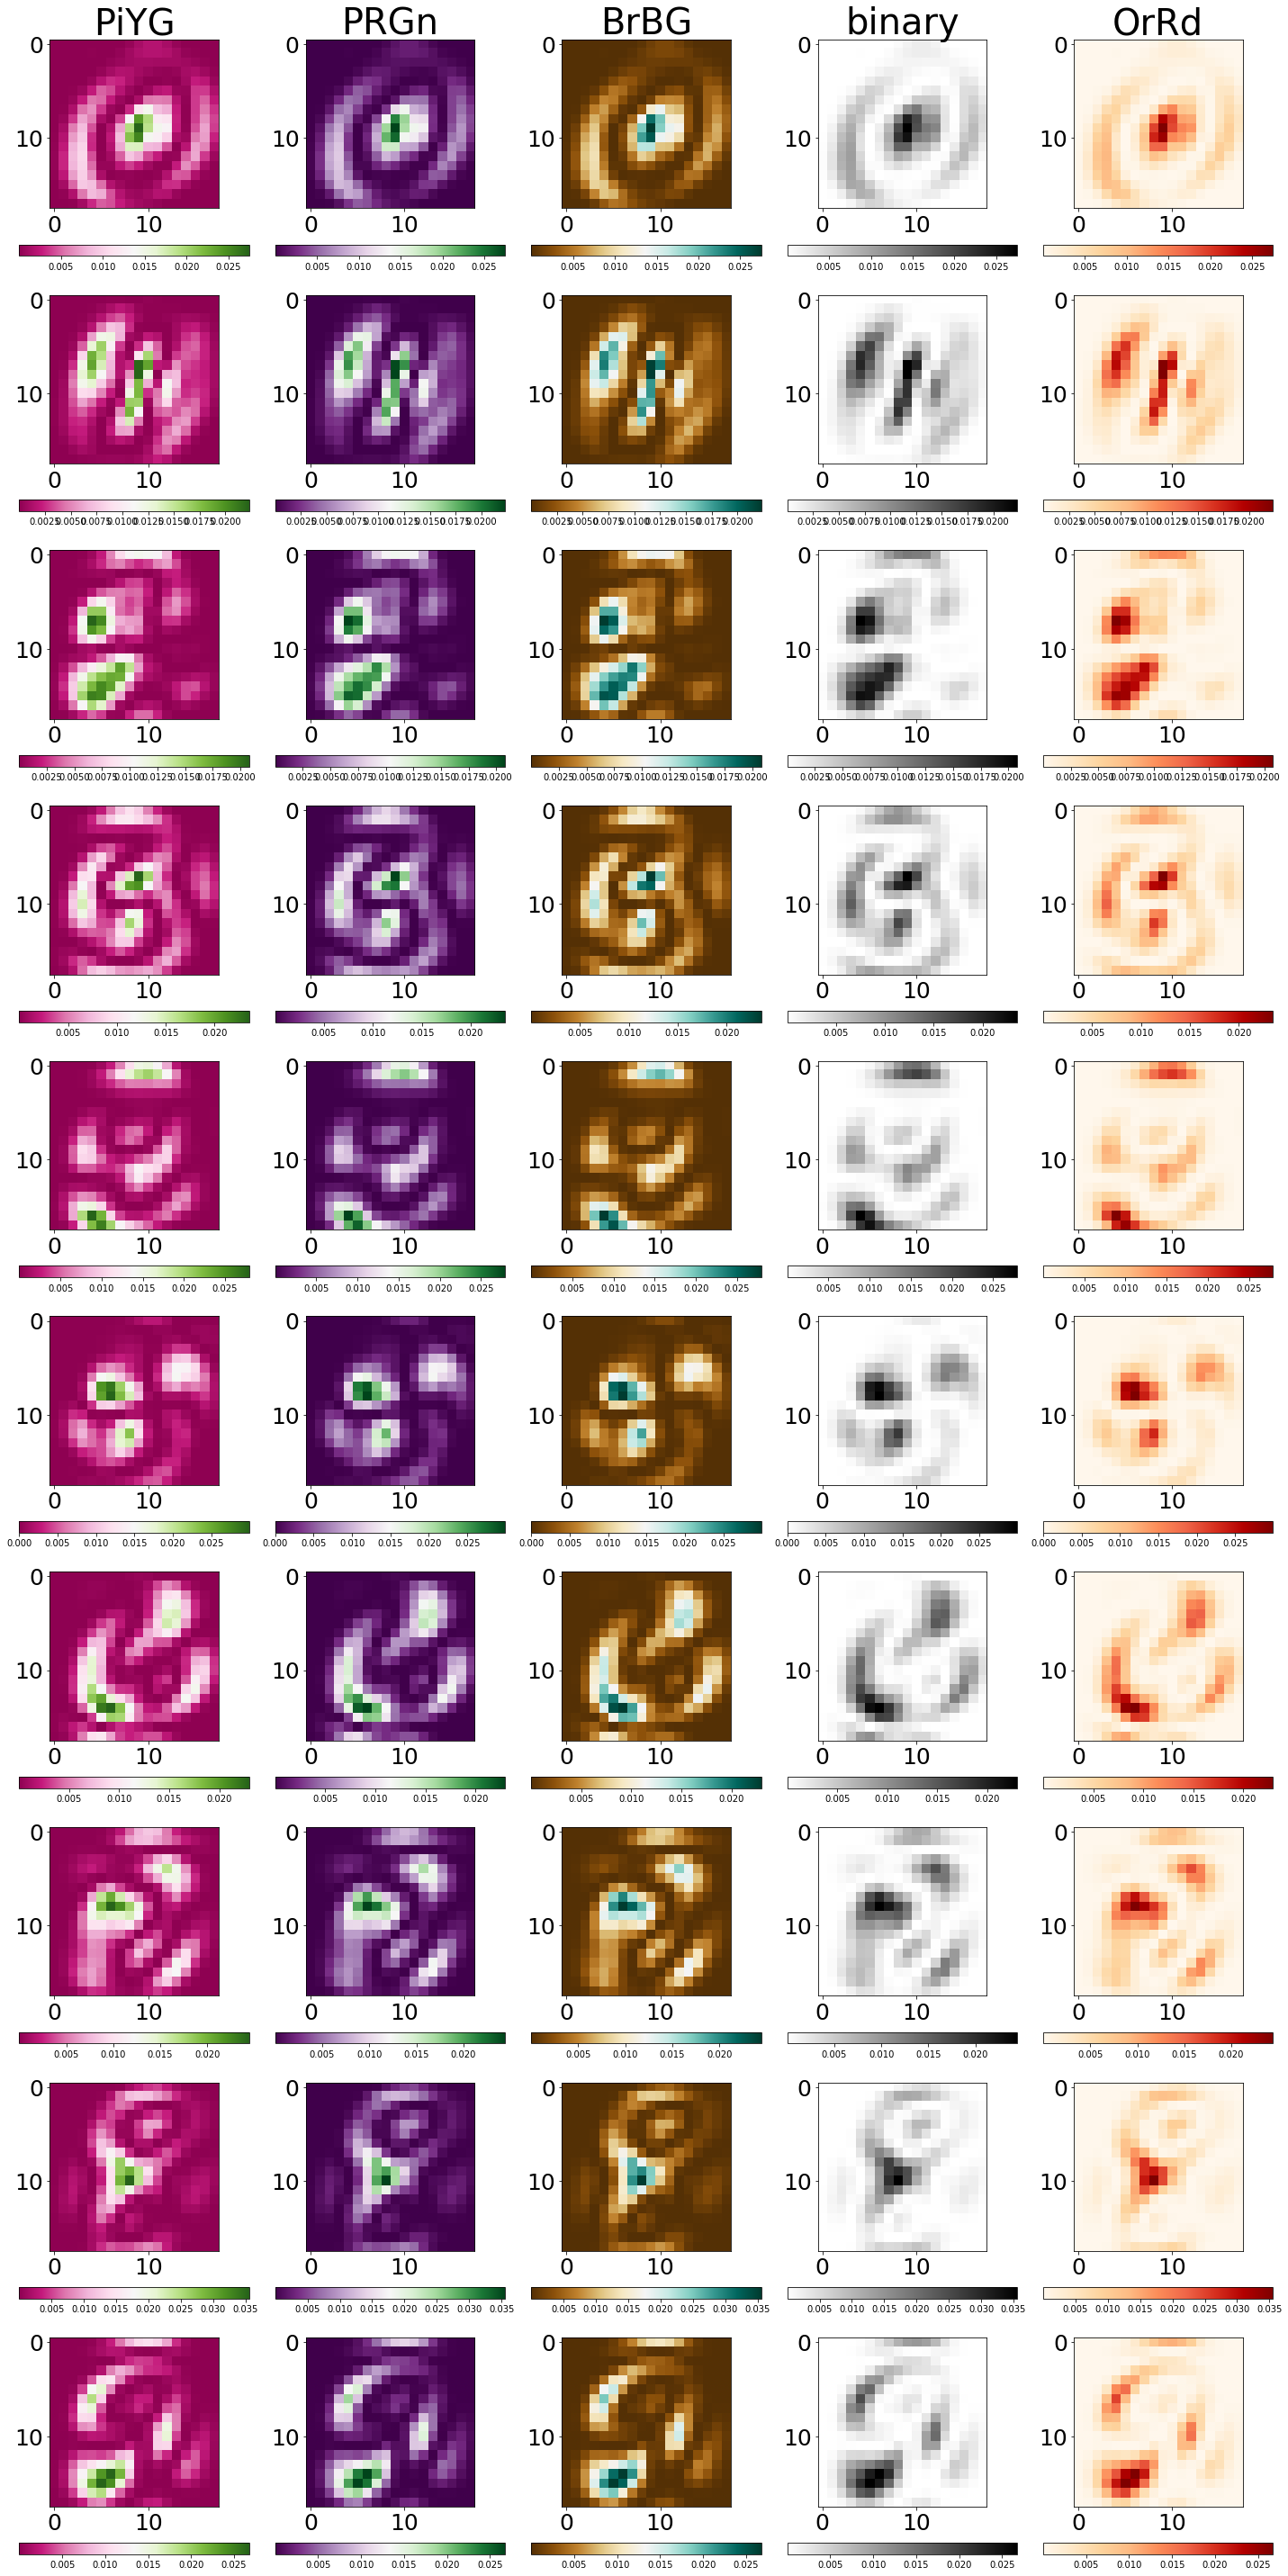

In [7]:
# Plot will have as many columns as there are colour maps in this list and one row per digit
cmaps = ["PiYG", "PRGn", "BrBG", "binary", "OrRd"] # CHANGE COLOUR MAPS HERE
plotsize = 4

fig, axes = plt.subplots(10, len(cmaps), figsize=(len(cmaps)*plotsize, 10*plotsize))

# Iterate over rows (classes/digits)
for i in range(10):
    # Iterate over colour maps
    for j in range(len(cmaps)):

        # Heatmaps
        im = axes[i,j].imshow(rate[i,:].reshape(image_size, image_size),
                                            interpolation="none",
                                            cmap=cmaps[j])

        # Colour bars
        fig.colorbar(im, ax=axes[i,j], orientation="horizontal")
        axes[i,j].tick_params("both", labelsize=tickfontsize)

# Set column titles
for j in range(len(cmaps)):
    axes[0,j].set_title(cmaps[j], fontsize=plottitlesize)
    
plt.tight_layout()

## RATE and ESA mean on the same plot

This will not be possible using black and white

### Using a Bivariate colour map - attempt 1

Using HSV - doesn't work well.

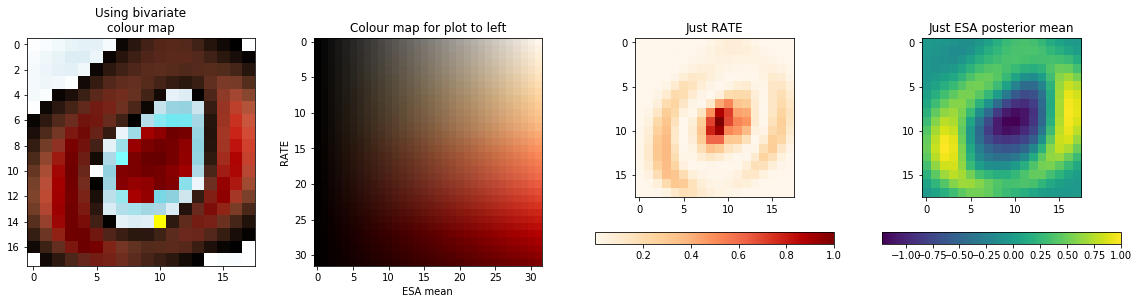

In [8]:
# Visualise with 2D colourmap
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

rate_colormap = "OrRd" # Choose colourmap here

idx = 0
A = rate[idx,:].reshape(image_size, image_size)
C = M_B[idx,:].reshape(image_size, image_size)
A = A/np.amax(A)
C = C/np.amax(C)

vmin = -0.75*A.ptp() # make axis 50% larger than max/min of trace
vmax = 0.75*A.ptp()
Anorm = 0.5 + (A / vmax)

img_array = plt.get_cmap(rate_colormap)(Anorm)

hsv = rgb_to_hsv(img_array[:,:,:3])
hsv[:, :, 2] *= C
corendered = hsv_to_rgb(hsv)

# Colorbar
from matplotlib import cm
from matplotlib.colors import makeMappingArray

seisbar = cm.get_cmap(rate_colormap) 
ncolours = 32
seis_array = makeMappingArray(ncolours, seisbar)

color_arr = seis_array[np.newaxis, :]  
color_arr = color_arr[:,:,:-1]

colour_roll = np.rollaxis(color_arr, 1)
seis_rgb_mtx = np.tile(colour_roll, (ncolours,1))

# fig, ax = plt.subplots()
# ax.imshow(seis_rgb_mtx)

seis_hsv = rgb_to_hsv(seis_rgb_mtx)

hues, lightness = np.mgrid[0:1:32j, 0:1.0:32j]
seis_hsv[:,:,2] *= lightness

# fig, ax = plt.subplots()
# ax.imshow(seis_hsv)

# RATE on vertical, ESA posterior mean on horizontal
RGB = hsv_to_rgb(seis_hsv)

fig, axes = plt.subplots(1, 4, figsize=(4*plotsize, plotsize))

# Heat maps
axes[0].imshow(corendered)
axes[1].imshow(RGB)
fig.colorbar(
        axes[2].imshow(A, cmap=rate_colormap),
        ax=axes[2],
        orientation="horizontal"
)
fig.colorbar(
        axes[3].imshow(C),
        ax=axes[3],
        orientation="horizontal"
)

# Set titles
axes[0].set_title("Using bivariate\ncolour map")
axes[1].set_title("Colour map for plot to left")
axes[2].set_title("Just RATE")
axes[3].set_title("Just ESA posterior mean")

# AXis labels for colour map
axes[1].set_xlabel("ESA mean")
axes[1].set_ylabel("RATE")

plt.tight_layout()

###  Using a Bivariate colour map - attempt 2

This is probably the best option if we want to show both RATE and mean ESA on the same plot, in my opinion

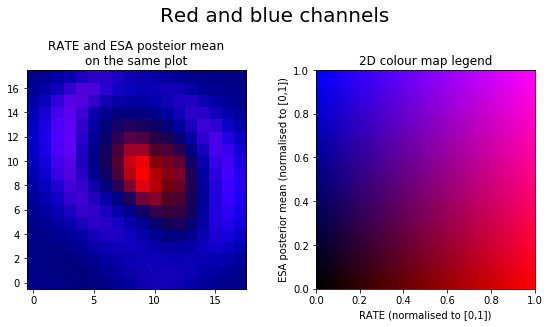

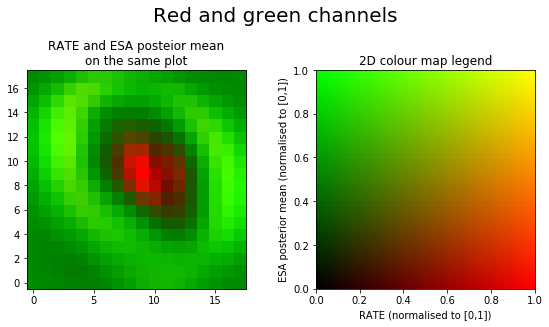

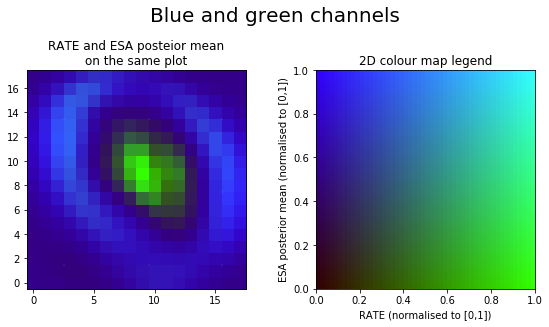

In [11]:
plotsize = 4

# Red and blue channels
fig, axes = plt.subplots(1, 2, figsize=(2*plotsize, plotsize))
fig.suptitle("Red and blue channels", fontsize=20, y=1.1)
axes[0].set_aspect("equal")

C0 = 0.0

# create a very simple colormap, 
#  mapping parameter 1 to the red channel and 
#          parameter 2 to the blue channel
cmap = lambda p1,p2 : (p1, C0, p2)

def draw_images_as_scatter(image0, image1, ax):
    
    all_i = np.array([[i for i in range(image_size)] for k in range(image_size)]).flatten()
    all_j = np.array([[j for k in range(image_size)] for j in range(image_size)]).flatten()
    tmp = np.vstack((all_i, all_j)).T
    
    norm_image0 = image0 / image0.max() # RATE is in [0,1] already
    norm_image1 = (image1-image1.min())/(image1.max()-image1.min()) # Rescale ESA mean to [0,1]
    
    def draw_pixel(i, j, k):
        ax.scatter(i, j, marker="s", s=122, color=cmap(norm_image0[k], norm_image1[k]))
        
    [draw_pixel(tmp[i,0], tmp[i,1], i) for i in range(tmp.shape[0])]
    
draw_images_as_scatter(rate[0,:], M_B[0,:], axes[0])
axes[0].set_title("RATE and ESA posteior mean\non the same plot")
axes[0].set_xlim([-0.5, image_size-0.5])
axes[0].set_ylim([-0.5, image_size-0.5])

# create the legend:
Cp1, Cp2 = np.meshgrid(np.linspace(0,1), np.linspace(0,1))

Legend = np.dstack((Cp1, C0*np.ones_like(Cp1), Cp2))

axes[1].imshow(Legend, origin="lower", extent=[0,1,0,1])
axes[1].set_xlabel("RATE (normalised to [0,1])")
axes[1].set_ylabel("ESA posterior mean (normalised to [0,1])")
axes[1].set_title("2D colour map legend")

plt.tight_layout()

#
# Red and green channels
#
fig, axes = plt.subplots(1, 2, figsize=(2*plotsize, plotsize))
fig.suptitle("Red and green channels", fontsize=20, y=1.1)
axes[0].set_aspect("equal")

# create a very simple colormap, 
#  mapping parameter 1 to the red channel and 
#          parameter 2 to the green channel
cmap = lambda p1,p2 : (p1, p2, 0)

def draw_images_as_scatter(image0, image1, ax):
    
    all_i = np.array([[i for i in range(image_size)] for k in range(image_size)]).flatten()
    all_j = np.array([[j for k in range(image_size)] for j in range(image_size)]).flatten()
    tmp = np.vstack((all_i, all_j)).T
    
    norm_image0 = image0 / image0.max() # RATE is in [0,1] already
    norm_image1 = (image1-image1.min())/(image1.max()-image1.min()) # Rescale ESA mean to [0,1]
    
    def draw_pixel(i, j, k):
        ax.scatter(i, j, marker="s", s=122, color=cmap(norm_image0[k], norm_image1[k]))
        
    [draw_pixel(tmp[i,0], tmp[i,1], i) for i in range(tmp.shape[0])]
    
draw_images_as_scatter(rate[0,:], M_B[0,:], axes[0])
axes[0].set_title("RATE and ESA posteior mean\non the same plot")
axes[0].set_xlim([-0.5, image_size-0.5])
axes[0].set_ylim([-0.5, image_size-0.5])

# create the legend:
Cp1, Cp2 = np.meshgrid(np.linspace(0,1), np.linspace(0,1))
C0 = np.zeros_like(Cp1)

Legend = np.dstack((Cp1, Cp2, C0))

axes[1].imshow(Legend, origin="lower", extent=[0,1,0,1])
axes[1].set_xlabel("RATE (normalised to [0,1])")
axes[1].set_ylabel("ESA posterior mean (normalised to [0,1])")
axes[1].set_title("2D colour map legend")

plt.tight_layout()

#
# Green and blue channels
#
fig, axes = plt.subplots(1, 2, figsize=(2*plotsize, plotsize))
fig.suptitle("Blue and green channels", fontsize=20, y=1.1)
axes[0].set_aspect("equal")

C0 = 0.2

# create a very simple colormap, 
#  mapping parameter 1 to the red channel and 
#          parameter 2 to the green channel
cmap = lambda p1,p2 : (C0, p1, p2)

def draw_images_as_scatter(image0, image1, ax):
    
    all_i = np.array([[i for i in range(image_size)] for k in range(image_size)]).flatten()
    all_j = np.array([[j for k in range(image_size)] for j in range(image_size)]).flatten()
    tmp = np.vstack((all_i, all_j)).T
    
    norm_image0 = image0 / image0.max() # RATE is in [0,1] already
    norm_image1 = (image1-image1.min())/(image1.max()-image1.min()) # Rescale ESA mean to [0,1]
    
    def draw_pixel(i, j, k):
        ax.scatter(i, j, marker="s", s=122, color=cmap(norm_image0[k], norm_image1[k]))
        
    [draw_pixel(tmp[i,0], tmp[i,1], i) for i in range(tmp.shape[0])]
    
draw_images_as_scatter(rate[0,:], M_B[0,:], axes[0])
axes[0].set_title("RATE and ESA posteior mean\non the same plot")
axes[0].set_xlim([-0.5, image_size-0.5])
axes[0].set_ylim([-0.5, image_size-0.5])

# create the legend:
Cp1, Cp2 = np.meshgrid(np.linspace(0,1), np.linspace(0,1))

Legend = np.dstack((C0*np.ones_like(Cp1), Cp1, Cp2))

axes[1].imshow(Legend, origin="lower", extent=[0,1,0,1])
axes[1].set_xlabel("RATE (normalised to [0,1])")
axes[1].set_ylabel("ESA posterior mean (normalised to [0,1])")
axes[1].set_title("2D colour map legend")

plt.tight_layout()

### Overlaying the two with one being transparent

We can overlay the RATE and mean effect size analogue plots with one having alpha (transparency) less than one.

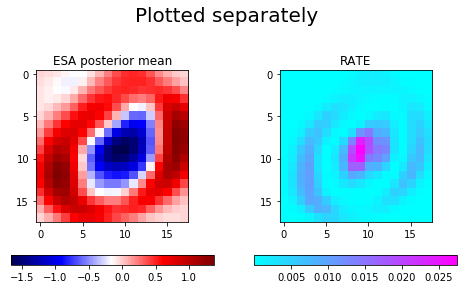

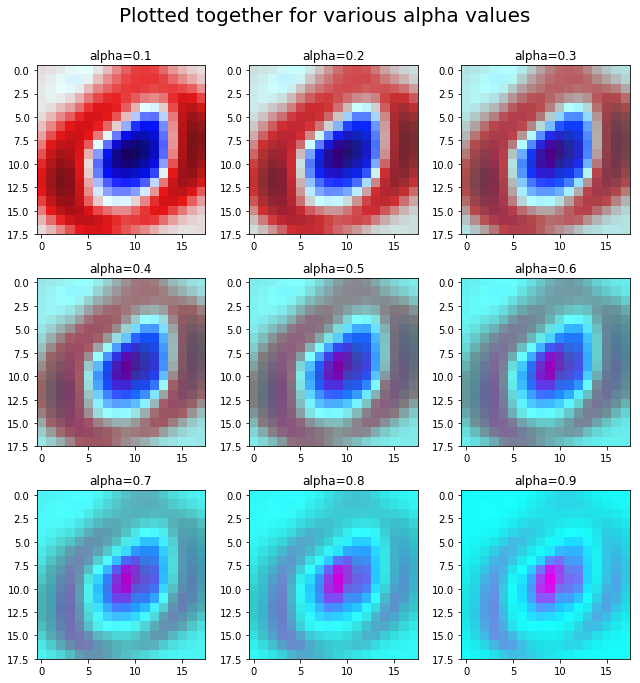

In [68]:
idx = 0
alpha_vals = np.linspace(0.1, 0.9, 9) # SET ALPHA SEQUENCE HERE - code below assumes there are 9 alpha values

plotsize = 3
cmaps = ["seismic", "binary"] # CHANGE COLOUR MAPS HERE - [mean ESA colour map, RATE colour map]

fig, axes = plt.subplots(1, 2, figsize=(2*(plotsize+1), plotsize+1))
fig.suptitle("Plotted separately", fontsize=20, y=1.1)
fig.colorbar(
        axes[0].imshow(
            M_B[idx,:].reshape(image_size, image_size), cmap=cmaps[0]),
        ax=axes[0],
        orientation="horizontal"
)
fig.colorbar(
        axes[1].imshow(
            rate[idx,:].reshape(image_size, image_size), cmap=cmaps[1]),
        ax=axes[1],
        orientation="horizontal"
)

axes[0].set_title("ESA posterior mean")
axes[1].set_title("RATE")

fig, axes = plt.subplots(3, 3, figsize=(3*plotsize, 3*plotsize))
fig.suptitle("Plotted together for various alpha values", fontsize=20, y=1.05)
for i, ax in enumerate(axes.flat):
    ax.set_title("alpha={}".format(alpha_vals[i]))
    ax.imshow(M_B[idx,:].reshape(image_size, image_size), cmap=cmaps[0])
    ax.imshow(rate[idx,:].reshape(image_size, image_size), cmap=cmaps[1], alpha=alpha_vals[i])

plt.tight_layout()

###  Masking pixels with low RATE values

Can try masking any pixels that have RATE < $1/p$, so that they will be transparent

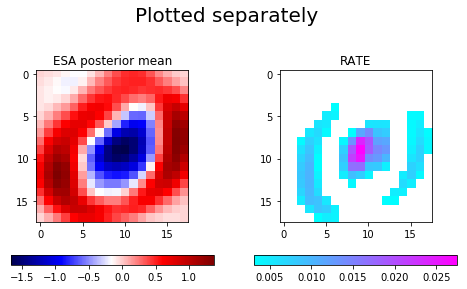

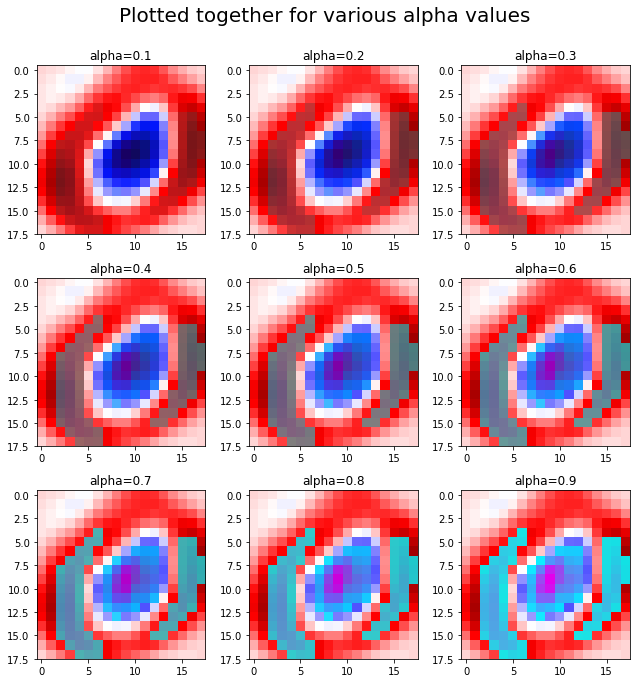

In [97]:
idx = 0
alpha_vals = np.linspace(0.1, 0.9, 9) # SET ALPHA SEQUENCE HERE - code below assumes there are 9 alpha values

plotsize = 3
cmaps = ["seismic", "cool"] # CHANGE COLOUR MAPS HERE - [mean ESA colour map, RATE colour map]

RATE_masked = np.ma.masked_where(rate[idx,:] < 1.0/rate[idx,:].shape[0], rate[idx,:]).reshape(image_size, image_size)

fig, axes = plt.subplots(1, 2, figsize=(2*(plotsize+1), plotsize+1))
fig.suptitle("Plotted separately", fontsize=20, y=1.1)
fig.colorbar(
        axes[0].imshow(
            M_B[idx,:].reshape(image_size, image_size), cmap=cmaps[0]),
        ax=axes[0],
        orientation="horizontal"
)
fig.colorbar(
        axes[1].imshow(
            RATE_masked.reshape(image_size, image_size), cmap=cmaps[1]),
        ax=axes[1],
        orientation="horizontal"
)

axes[0].set_title("ESA posterior mean")
axes[1].set_title("RATE")

fig, axes = plt.subplots(3, 3, figsize=(3*plotsize, 3*plotsize))
fig.suptitle("Plotted together for various alpha values", fontsize=20, y=1.05)
for i, ax in enumerate(axes.flat):
    ax.set_title("alpha={}".format(alpha_vals[i]))
    ax.imshow(M_B[idx,:].reshape(image_size, image_size), cmap=cmaps[0])
    ax.imshow(RATE_masked.reshape(image_size, image_size), cmap=cmaps[1], alpha=alpha_vals[i])

plt.tight_layout()